In [73]:
%matplotlib inline

In [74]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import simpy

In [ ]:
# Global variables
# Copied from the MDP code

# Queue size
MAX_QUEUE_SIZE = 20

# Arrival average of customers per unit time (Poisson process)
ARRIVAL_SIMPLE = 12
ARRIVAL_COMPLEX = 5

# Service rate of agents for each query types (Exponential distribution)
## Agent 1
SERVICE_SIMPLE_1 = 12
SERVICE_COMPLEX_1 = 3
## Agent 2
SERVICE_SIMPLE_2 = 6
SERVICE_COMPLEX_2 = 5

In [76]:
# Data collection lists
waiting_times = []
agent_utilisations = {'Agent 1 Simple': 0,
                      'Agent 1 Complex': 0,
                      'Agent 2 Simple': 0,
                      'Agent 2 Complex': 0,
                      'Dropped Calls': 0}
queue_lengths = []
queue_length_times = []

In [77]:
def get_policy_decision(policy_simple, policy_complex, q1, q2, call_type):
    """
    Get the policy decision based on the current state.
    returns the action to take (0 to agent1 or 1 to agent2).
    """
    
    # Ensure we don't exceed the maximum queue size
    q1 = min(q1, MAX_QUEUE_SIZE)
    q2 = min(q2, MAX_QUEUE_SIZE)
    
    if call_type == 'Simple':
        return policy_simple[q1, q2]
    else:
        return policy_complex[q1, q2]


def handle_call(env, policy_simple, policy_complex, call_type, agent1, agent2):
    """Handle the call from arrival to completion."""
    arrival_time = env.now
    
    # Get current queue sizes
    q1 = len(agent1.queue) + (1 if agent1.count > 0 else 0)
    q2 = len(agent2.queue) + (1 if agent2.count > 0 else 0)
    
    # Check if queues are full
    q1_full = q1 >= MAX_QUEUE_SIZE
    q2_full = q2 >= MAX_QUEUE_SIZE
    
    decision = get_policy_decision(policy_simple, policy_complex, q1, q2, call_type)
    
    # Route to selected queue if not full
    if decision == 0 and not q1_full:
        queue = agent1
    elif decision == 1 and not q2_full:
        queue = agent2
    elif not q1_full:
        queue = agent1
        decision = 0
    elif not q2_full:
        queue = agent2
        decision = 1
    else:
        # Both queues are full, drop the call
        agent_utilisations['Dropped Calls'] += 1
        print(f'{call_type} call dropped at {env.now}')
        return
    
    # Get into the queue and request service
    with queue.request() as req:
        yield req
        
        # Call is being served
        service_start_time = env.now
        waiting_time = service_start_time - arrival_time
        
        # Determine service time based on agent and call type
        if decision == 0:
            service_rate = SERVICE_SIMPLE_1 if call_type == 'Simple' else SERVICE_COMPLEX_1
        else:
            service_rate = SERVICE_SIMPLE_2 if call_type == 'Simple' else SERVICE_COMPLEX_2
            
        service_time = random.expovariate(service_rate)
        
        # Serve the call
        yield env.timeout(service_time)
        
        # Call completed
        completion_time = env.now
        total_time = completion_time - arrival_time
        
        # Record statistics
        waiting_times.append({
            'call_type': call_type,
            'queue': decision + 1,
            'arrival_time': arrival_time,
            'waiting_time': waiting_time,
            'service_time': service_time,
            'total_time': total_time
        })
        
        # Update agent utilisation
        agent_utilisations[f'Agent {decision + 1} {call_type}'] += 1

def simple_call_generator(env, policy_simple, policy_complex, queue1, queue2):
    """Generate simple calls according to a Poisson process."""
    while True:
        interarrival_time = random.expovariate(ARRIVAL_SIMPLE)
        yield env.timeout(interarrival_time)
        
        # Create a new call
        env.process(handle_call(env, policy_simple, policy_complex, 'Simple', queue1, queue2))
        
def complex_call_generator(env, policy_simple, policy_complex, queue1, queue2):
    """Generate complex calls according to a Poisson process."""
    while True:
        interarrival_time = random.expovariate(ARRIVAL_COMPLEX)
        yield env.timeout(interarrival_time)
        
        # Create a new call
        env.process(handle_call(env, policy_simple, policy_complex, 'Complex', queue1, queue2))
        
def record_queue_length(env, queue1, queue2):
    """Record the lengths of the queues at regular intervals."""
    while True:
        # Queue length includes the customer being served
        queue1_len = len(queue1.queue) + (1 if queue1.count > 0 else 0)
        queue2_len = len(queue2.queue) + (1 if queue2.count > 0 else 0)
        
        queue_lengths.append((
            queue1_len,
            queue2_len,
            env.now
        ))
        queue_length_times.append(env.now)
        
        yield env.timeout(0.1)

In [78]:
# Get results from the simulation
def get_results():
    """Compute and return the results of the simulation."""
    # Convert waiting times to DataFrame
    df_waiting = pd.DataFrame(waiting_times)
    
    # Calculate average metrics
    avg_waiting_time = df_waiting['waiting_time'].mean() if not df_waiting.empty else 0
    avg_service_time = df_waiting['service_time'].mean() if not df_waiting.empty else 0
    avg_total_time = df_waiting['total_time'].mean() if not df_waiting.empty else 0
    
    # Calculate metrics by call type
    avg_waiting_by_type = df_waiting.groupby('call_type')['waiting_time'].mean().to_dict() if not df_waiting.empty else {}
    avg_service_by_type = df_waiting.groupby('call_type')['service_time'].mean().to_dict() if not df_waiting.empty else {}
    
    # Calculate metrics by queue
    avg_waiting_by_queue = df_waiting.groupby('queue')['waiting_time'].mean().to_dict() if not df_waiting.empty else {}
    
    # Extract queue lengths and times
    queue_data = pd.DataFrame(queue_lengths, columns=['Queue 1 Length', 'Queue 2 Length', 'Time'])
    avg_queue_length = [queue_data['Queue 1 Length'].mean(), queue_data['Queue 2 Length'].mean()]
    
    # Calculate call volumes
    completed_calls = agent_utilisations['Agent 1 Simple'] + agent_utilisations['Agent 1 Complex'] + \
                    agent_utilisations['Agent 2 Simple'] + agent_utilisations['Agent 2 Complex']
    total_calls = completed_calls + agent_utilisations['Dropped Calls']
    
    call_counts = {
        'total': total_calls,
        'completed': completed_calls,
        'simple': agent_utilisations['Agent 1 Simple'] + agent_utilisations['Agent 2 Simple'],
        'complex': agent_utilisations['Agent 1 Complex'] + agent_utilisations['Agent 2 Complex'],
        'agent1': agent_utilisations['Agent 1 Simple'] + agent_utilisations['Agent 1 Complex'],
        'agent2': agent_utilisations['Agent 2 Simple'] + agent_utilisations['Agent 2 Complex'],
        'dropped': agent_utilisations['Dropped Calls'],
        'drop_rate': agent_utilisations['Dropped Calls'] / total_calls if total_calls > 0 else 0
        }
    
    # Combine all results into a dictionary
    results = {
        'call_counts': call_counts,
        'avg_waiting_time': avg_waiting_time,
        'avg_service_time': avg_service_time,
        'avg_total_time': avg_total_time,
        'avg_waiting_by_type': avg_waiting_by_type,
        'avg_service_by_type': avg_service_by_type,
        'avg_waiting_by_queue': avg_waiting_by_queue,
        'avg_queue_length': avg_queue_length,
        'waiting_times_df': df_waiting,
        'queue_data': queue_data
    }
    
    return results
    

# Run the simulation
def run_simulation(policy_simple, policy_complex, sim_time=1000):
    """Run the simulation for a given time."""
    env = simpy.Environment()
    
    # Set random seed for reproducibility
    np.random.seed(42)
    random.seed(42)
    
    # Reset global variables
    global waiting_times, agent_utilisations, queue_lengths, queue_length_times
    waiting_times = []
    agent_utilisations = {'Agent 1 Simple': 0,
                            'Agent 1 Complex': 0,
                            'Agent 2 Simple': 0,
                            'Agent 2 Complex': 0,
                            'Dropped Calls': 0}
    queue_lengths = []
    queue_length_times = []
    
    agent1 = simpy.Resource(env, capacity=1)
    agent2 = simpy.Resource(env, capacity=1)
    
    # Start call generators
    env.process(simple_call_generator(env, policy_simple, policy_complex, agent1, agent2))
    env.process(complex_call_generator(env, policy_simple, policy_complex, agent1, agent2))
    
    # Start queue length recorder
    env.process(record_queue_length(env, agent1, agent2))
    
    # Run the simulation
    env.run(until=sim_time)
    
    # Get results
    results = get_results()
    return results
    
# Plotting functions

def plot_policies(policy_simple, policy_complex):
    """Plot the policies for simple and complex calls."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    sns.heatmap(policy_simple, cmap="YlGnBu", annot=True, fmt=".0f", cbar=False, ax=axes[0])
    axes[0].set_title('Policy for Simple Calls')
    axes[0].set_xlabel('Queue 2 Size')
    axes[0].set_ylabel('Queue 1 Size')
    
    sns.heatmap(policy_complex, cmap="YlOrBr", annot=True, fmt=".0f", cbar=False, ax=axes[1])
    axes[1].set_title('Policy for Complex Calls')
    axes[1].set_xlabel('Queue 2 Size')
    axes[1].set_ylabel('Queue 1 Size')
    
    plt.tight_layout()
    plt.show()
    
def plot_queue_length_over_time(results):
    """Plot the queue lengths over time."""
    queue_data = results['queue_data']
    
    plt.figure(figsize=(12, 6))
    plt.plot(queue_data['Time'], queue_data['Queue 1 Length'], label='Queue 1 Length', color='blue')
    plt.plot(queue_data['Time'], queue_data['Queue 2 Length'], label='Queue 2 Length', color='orange')
    
    plt.title('Queue Lengths Over Time')
    plt.xlabel('Time')
    plt.ylabel('Queue Length')
    plt.legend()
    plt.grid()
    plt.show()
    
def plot_waiting_times_by_queue(results):
    """Plot the average waiting times by queue."""
    df_waiting = results['waiting_times_df']
    
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df_waiting, x='queue', y='waiting_time')
    
    plt.title('Average Waiting Time by Queue')
    plt.xlabel('Queue')
    plt.ylabel('Average Waiting Time')
    plt.grid()
    plt.show()

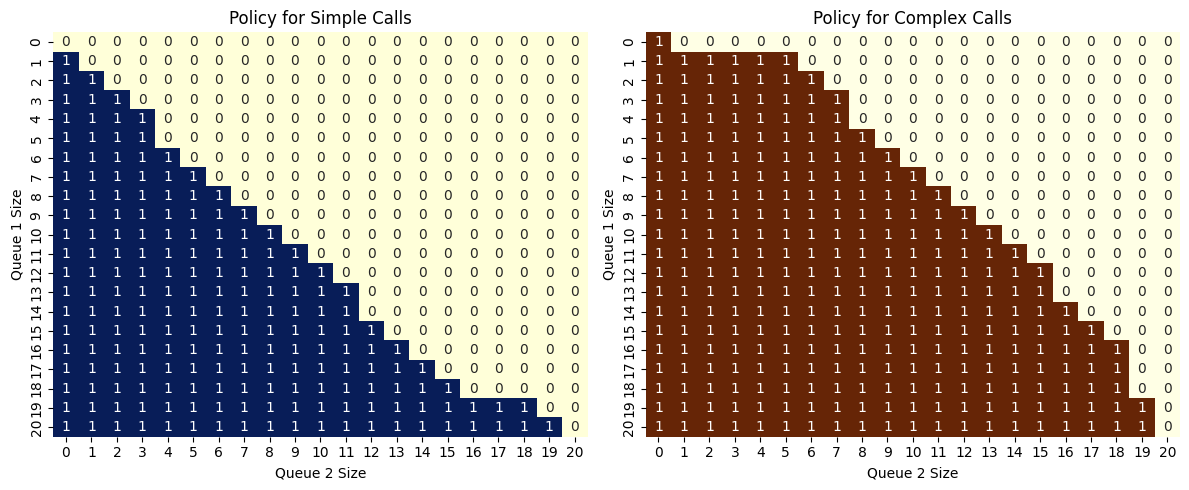

In [79]:
# Load optimal policy from the pickle file
# with open('policy_simple.pkl', 'rb') as f:
#     opt_simple_policy = pickle.load(f)
# with open('policy_complex.pkl', 'rb') as f:
#     opt_complex_policy = pickle.load(f)
    
with open('policy_simple_withdrop.pkl', 'rb') as f:
    opt_simple_policy = pickle.load(f)
with open('policy_complex_withdrop.pkl', 'rb') as f:
    opt_complex_policy = pickle.load(f)

# Set runtime for the simulation
RUNTIME = 24  # Simulate for 24 hours

# Plot the policies
plot_policies(opt_simple_policy, opt_complex_policy)

In [80]:
# Run the simulation
results = run_simulation(opt_simple_policy, opt_complex_policy, sim_time=RUNTIME)


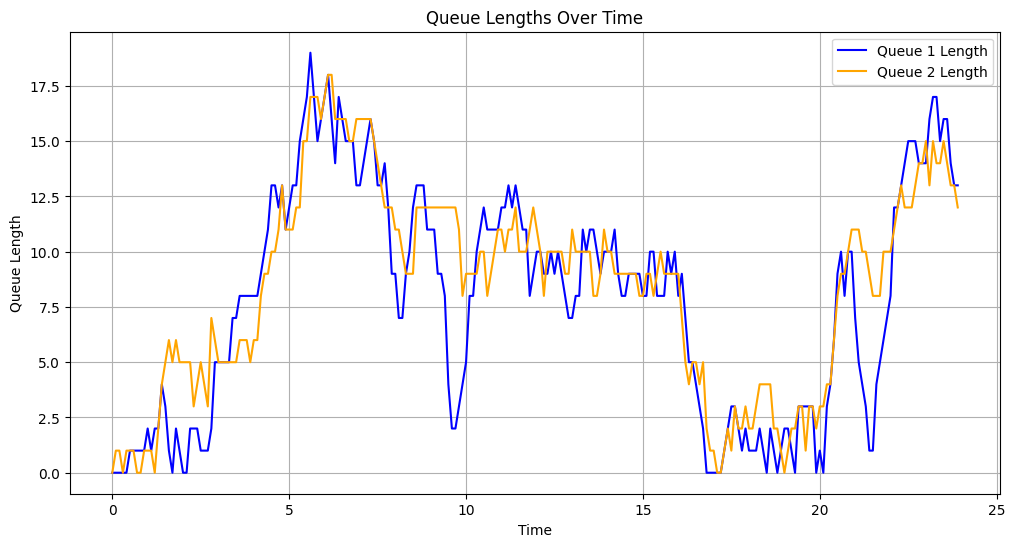

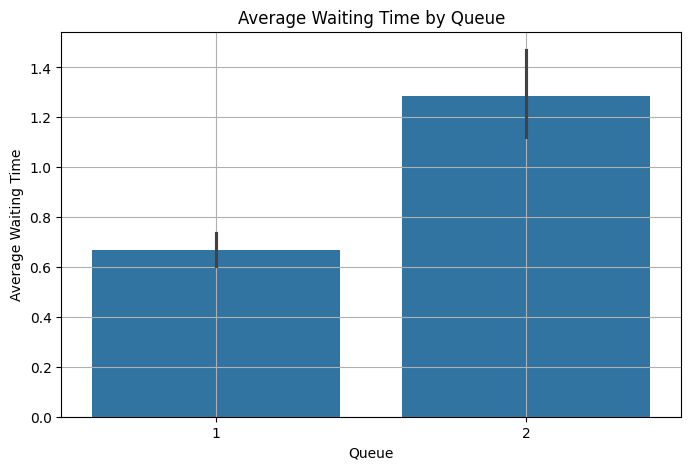

In [81]:
# Plot the results

plot_queue_length_over_time(results)
plot_waiting_times_by_queue(results)

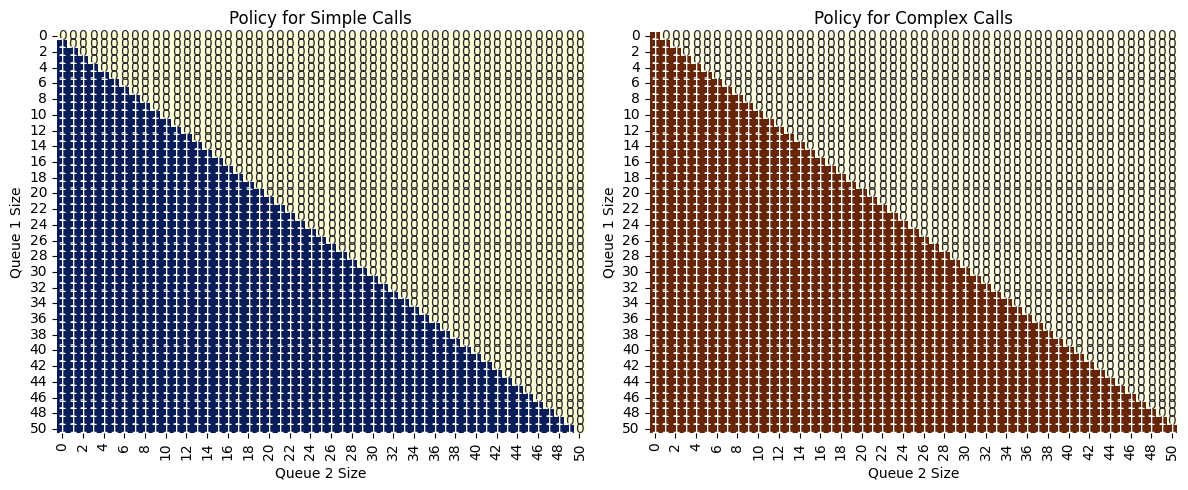

In [82]:
# Create another policy for comparison
# Route calls to the queue with the least number of calls
# If both queues size are equal, route simple calls to queue 1 and complex calls to queue 2
alt_simple_policy = np.zeros((MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1), dtype=int)
for i in range(MAX_QUEUE_SIZE + 1):
    for j in range(MAX_QUEUE_SIZE + 1):
        if i < j:
            alt_simple_policy[i, j] = 0  # Route to queue 1
        elif i > j:
            alt_simple_policy[i, j] = 1  # Route to queue 2
            
alt_complex_policy = np.ones((MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1), dtype=int)
for i in range(MAX_QUEUE_SIZE + 1):
    for j in range(MAX_QUEUE_SIZE + 1):
        if i < j:
            alt_complex_policy[i, j] = 0  # Route to queue 1
        elif i > j:
            alt_complex_policy[i, j] = 1  # Route to queue 2
            
# Plot the new policies
plot_policies(alt_simple_policy, alt_complex_policy)

In [83]:
# Run the simulation
results_2 = run_simulation(alt_simple_policy, alt_complex_policy, sim_time=RUNTIME)


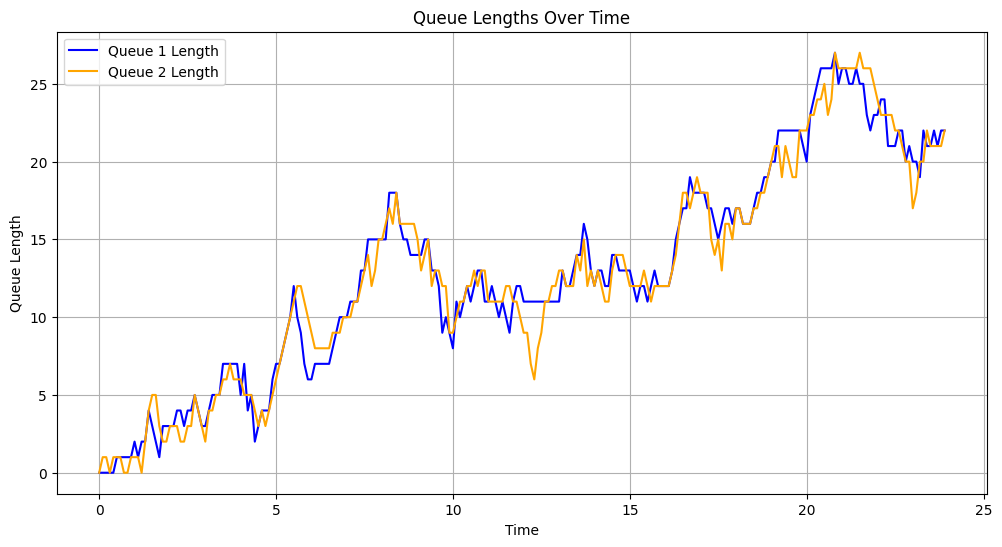

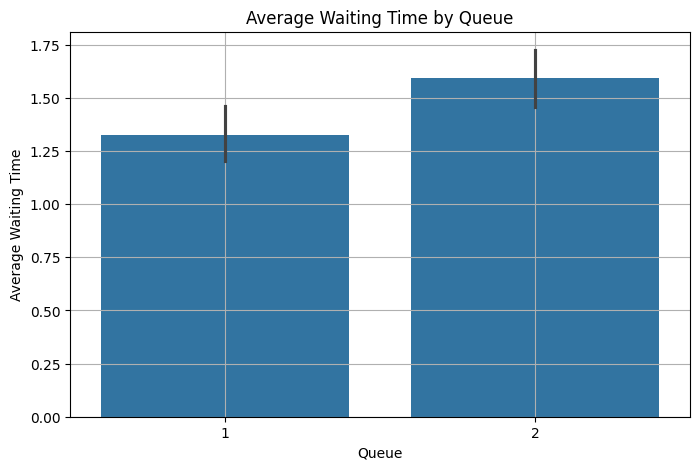

In [84]:
# Plot the results

plot_queue_length_over_time(results_2)
plot_waiting_times_by_queue(results_2)

In [85]:
# Simulate for a week (168 hours)

results_week = run_simulation(opt_simple_policy, opt_complex_policy, sim_time=168)
# Plot the results for the week
plot_queue_length_over_time(results_week)
plot_waiting_times_by_queue(results_week)

IndexError: index 21 is out of bounds for axis 0 with size 21

Complex call dropped at 19.03035778530023
Simple call dropped at 19.146538894356276
Simple call dropped at 19.154093081194628
Simple call dropped at 19.77379086317315
Complex call dropped at 19.800624026854397
Complex call dropped at 19.818524295248732
Simple call dropped at 20.127854394511637
Simple call dropped at 20.200455329366804
Simple call dropped at 20.253876090926106
Simple call dropped at 20.316958263115865
Simple call dropped at 20.363146747972362
Simple call dropped at 20.482101036870137
Simple call dropped at 20.745799429720975
Simple call dropped at 20.76378421519112
Simple call dropped at 20.786480122290747
Simple call dropped at 36.90653580577404
Complex call dropped at 37.02596517974087
Simple call dropped at 37.1056456113894
Simple call dropped at 37.24283000715402
Simple call dropped at 37.38500473454682
Simple call dropped at 37.4664562050324
Simple call dropped at 37.970585322199085
Simple call dropped at 37.99077205965377
Simple call dropped at 38.218415616279366


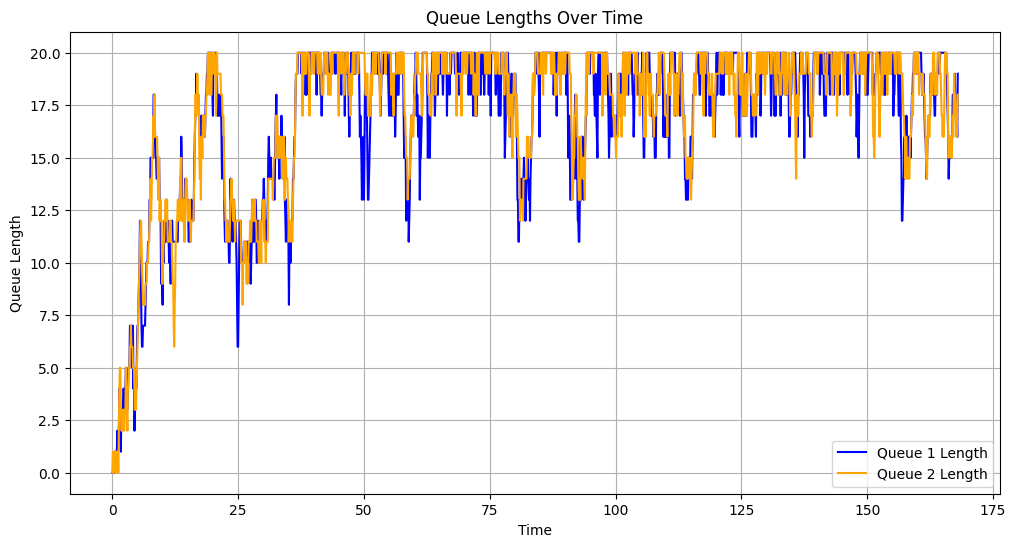

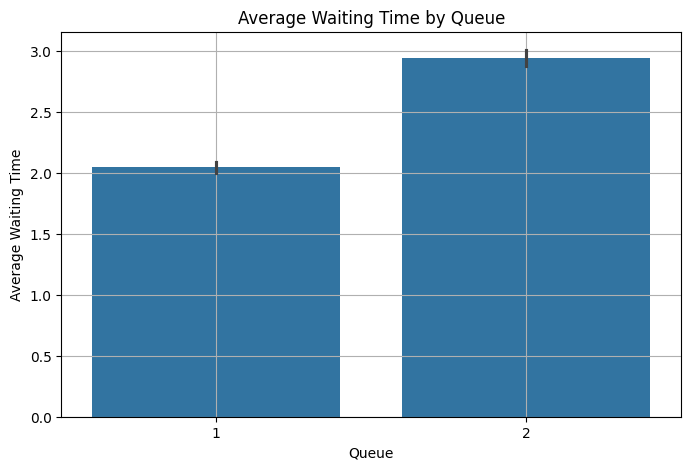

In [ ]:
results_week_2 = run_simulation(alt_simple_policy, alt_complex_policy, sim_time=168)
# Plot the results for the week
plot_queue_length_over_time(results_week_2)
plot_waiting_times_by_queue(results_week_2)

Simple call dropped at 58.92873572328166
Simple call dropped at 61.10431993651821
Complex call dropped at 62.03679002176498
Simple call dropped at 70.08678192751795
Complex call dropped at 70.2421254556151
Simple call dropped at 71.71912536678859
Simple call dropped at 71.92744518069263
Simple call dropped at 71.96737994582135
Simple call dropped at 71.97983619830919
Simple call dropped at 72.00969389369412
Complex call dropped at 74.68512068352389
Simple call dropped at 74.70801140008734
Simple call dropped at 74.73296153672273
Simple call dropped at 75.01760554732678
Simple call dropped at 75.5335142498858
Simple call dropped at 75.7262283112565
Simple call dropped at 75.74077122468715
Simple call dropped at 75.8091576681192
Simple call dropped at 76.67867179898712
Complex call dropped at 76.70213925445444
Complex call dropped at 76.89427279082899
Simple call dropped at 77.03223470368492
Simple call dropped at 77.25939931982278
Complex call dropped at 79.16577199910986
Simple call dr

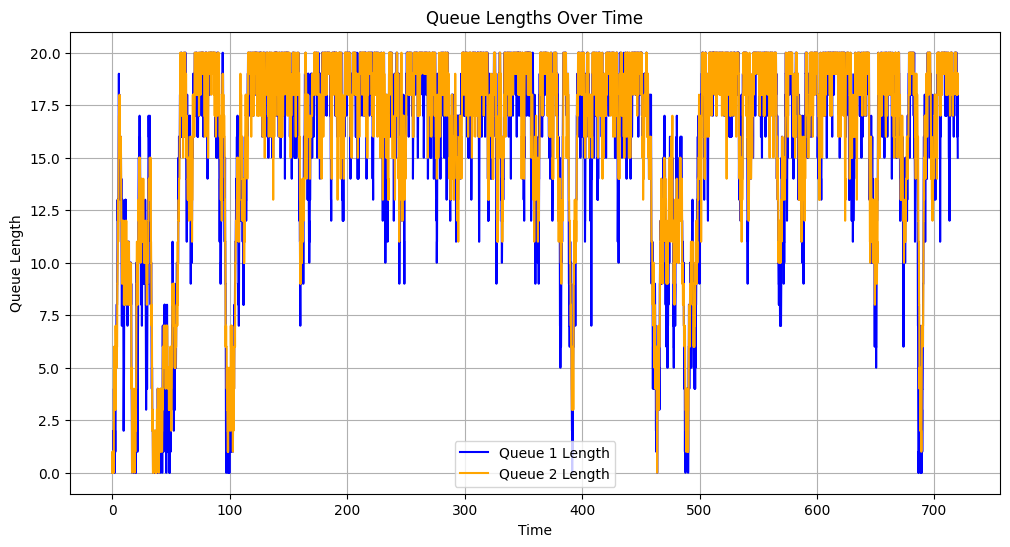

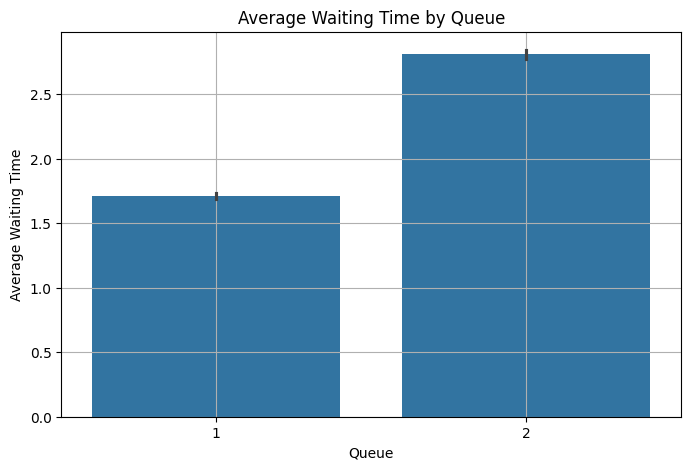

In [ ]:
# Simulate for a month (720 hours)
results_month = run_simulation(opt_simple_policy, opt_complex_policy, sim_time=720)
# Plot the results for the month
plot_queue_length_over_time(results_month)
plot_waiting_times_by_queue(results_month)

Complex call dropped at 19.03035778530023
Simple call dropped at 19.146538894356276
Simple call dropped at 19.154093081194628
Simple call dropped at 19.77379086317315
Complex call dropped at 19.800624026854397
Complex call dropped at 19.818524295248732
Simple call dropped at 20.127854394511637
Simple call dropped at 20.200455329366804
Simple call dropped at 20.253876090926106
Simple call dropped at 20.316958263115865
Simple call dropped at 20.363146747972362
Simple call dropped at 20.482101036870137
Simple call dropped at 20.745799429720975
Simple call dropped at 20.76378421519112
Simple call dropped at 20.786480122290747
Simple call dropped at 36.90653580577404
Complex call dropped at 37.02596517974087
Simple call dropped at 37.1056456113894
Simple call dropped at 37.24283000715402
Simple call dropped at 37.38500473454682
Simple call dropped at 37.4664562050324
Simple call dropped at 37.970585322199085
Simple call dropped at 37.99077205965377
Simple call dropped at 38.218415616279366


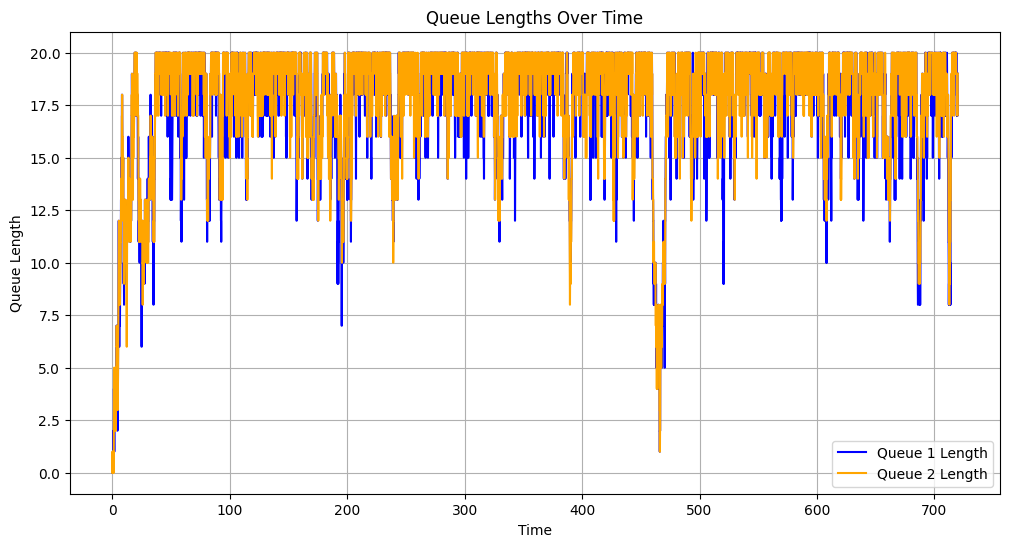

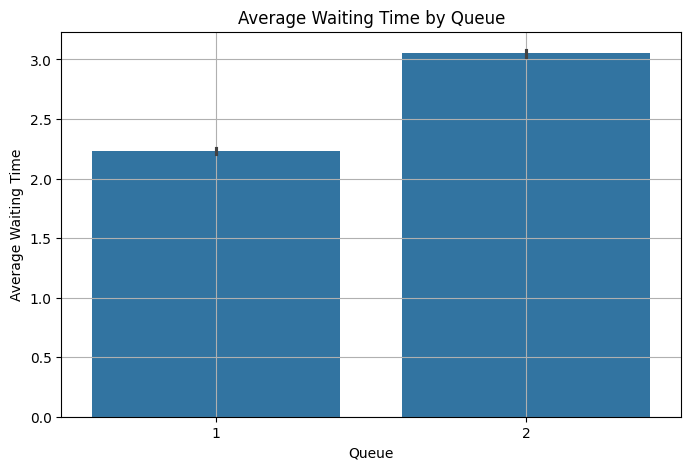

In [ ]:
results_month_2 = run_simulation(alt_simple_policy, alt_complex_policy, sim_time=720)
# Plot the results for the month
plot_queue_length_over_time(results_month_2)
plot_waiting_times_by_queue(results_month_2)

In [68]:
def metrics_df(results_a, results_b):
    """Create a metrics comparison DataFrame for two sets of results."""
    df = pd.DataFrame({
        'Metric': ['Average Waiting Time', 'Average Service Time', 'Average Total Time',
                    'Average Waiting Time Simple', 'Average Waiting Time Complex',
                    'Average Waiting Time Queue 1', 'Average Waiting Time Queue 2',
                'Average Queue Length 1', 'Average Queue Length 2'],
        'Optimal Policy': [results_a['avg_waiting_time'], results_a['avg_service_time'], results_a['avg_total_time'],
                           results_a['avg_waiting_by_type']['Simple'], results_a['avg_waiting_by_type']['Complex'],
                           results_a['avg_waiting_by_queue'][1], results_a['avg_waiting_by_queue'][2],
                        results_a['avg_queue_length'][0], results_a['avg_queue_length'][1]],
        'Generated Policy': [results_b['avg_waiting_time'], results_b['avg_service_time'], results_b['avg_total_time'],
                           results_b['avg_waiting_by_type']['Simple'], results_b['avg_waiting_by_type']['Complex'],
                           results_b['avg_waiting_by_queue'][1], results_b['avg_waiting_by_queue'][2],
                    results_b['avg_queue_length'][0], results_b['avg_queue_length'][1]]
    })
    df.set_index('Metric', inplace=True)
    df['Delta'] = df['Optimal Policy'] - df['Generated Policy']
    
    return df

In [72]:
# Compare metrics between the two policies with different runtimes
day_df = metrics_df(results, results_2)
week_df = metrics_df(results_week, results_week_2)
month_df = metrics_df(results_month, results_month_2)

# Display the comparison
print("\nComparison of Metrics Between Policies (One Day):")
print(day_df)
print("\nComparison of Metrics Between Policies (One Week):")
print(week_df)
print("\nComparison of Metrics Between Policies (One Month):")
print(month_df)


Comparison of Metrics Between Policies (One Day):
                              Optimal Policy  Generated Policy     Delta
Metric                                                                  
Average Waiting Time                0.898389          1.375524 -0.477134
Average Service Time                0.128436          0.136215 -0.007779
Average Total Time                  1.026826          1.511739 -0.484913
Average Waiting Time Simple         0.789464          1.315505 -0.526042
Average Waiting Time Complex        1.177240          1.527407 -0.350167
Average Waiting Time Queue 1        0.669655          1.237272 -0.567617
Average Waiting Time Queue 2        1.286545          1.560482 -0.273938
Average Queue Length 1              7.812500         11.483333 -3.670833
Average Queue Length 2              8.387500         11.487500 -3.100000

Comparison of Metrics Between Policies (One Week):
                              Optimal Policy  Generated Policy     Delta
Metric               

In [70]:
def volume_df(results_a, results_b):
    """Create a volume comparison DataFrame for two sets of results."""
    df = pd.DataFrame({
        'Metric': ['Total Calls', 'Completed Calls',
                'Agent 1 Calls', 'Agent 2 Calls', 'Dropped Calls'],
        'Optimal Policy': [results_a['call_counts']['total'], results_a['call_counts']['completed'],
                        results_a['call_counts']['agent1'], results_a['call_counts']['agent2'],
                        results_a['call_counts']['dropped']],
        'Generated Policy': [results_b['call_counts']['total'], results_b['call_counts']['completed'],
                            results_b['call_counts']['agent1'], results_b['call_counts']['agent2'],
                            results_b['call_counts']['dropped']]
    })
    df.set_index('Metric', inplace=True)
    df['Delta'] = df['Optimal Policy'] - df['Generated Policy']
    
    return df

In [71]:
# Compare call volumes between the two policies
call_volume_day = volume_df(results, results_2)
call_volume_week = volume_df(results_week, results_week_2)
call_volume_month = volume_df(results_month, results_month_2)

# Display the call volume comparison
print("\nComparison of Call Volumes Between Policies (One Day):")
print(call_volume_day)
print("\nComparison of Call Volumes Between Policies (One Week):")
print(call_volume_week)
print("\nComparison of Call Volumes Between Policies (One Month):")
print(call_volume_month)


Comparison of Call Volumes Between Policies (One Day):
                 Optimal Policy  Generated Policy  Delta
Metric                                                  
Total Calls                 356               361     -5
Completed Calls             356               346     10
Agent 1 Calls               224               198     26
Agent 2 Calls               132               148    -16
Dropped Calls                 0                15    -15

Comparison of Call Volumes Between Policies (One Week):
                 Optimal Policy  Generated Policy  Delta
Metric                                                  
Total Calls                2758              2825    -67
Completed Calls            2514              2215    299
Agent 1 Calls              1591              1300    291
Agent 2 Calls               923               915      8
Dropped Calls               244               610   -366

Comparison of Call Volumes Between Policies (One Month):
                 Optimal Policy